# Mapping chemically peculiar stars

In this notebook, we generate a synthetic light curve of an inclined star whose surface is described by a simple isotropic gaussian power spectrum. Given the light curve and (precise) knowledge of the map's power spectrum, we attempt to infer the inclination and orbital period of the star by marginalizing over all maps.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'
import theano.tensor as tt

## Generate the dataset

Generate a 10th degree spherical harmonic map sampled from an isotropic gaussian power spectrum and compute its light curve:

In [4]:
# True values
truths = {
    "inc":      60.0,
    "period":   8.53,
    "ydeg":     10,
    "p_amp":    0.002,
    "p_sig":    3.0,
    "flux_err": 0.001
}

# Generate a power spectrum
truths["power"] = np.array([truths["p_amp"] * np.exp(-0.5 * (l / truths["p_sig"]) ** 2) 
                            for l in range(1, truths["ydeg"] + 1) for m in range(-l, l + 1)])

# Draw a map from this spectrum
np.random.seed(43)
truths["y"] = np.random.randn((truths["ydeg"] + 1) ** 2 - 1) * np.sqrt(truths["power"])

# Generate a synthetic dataset
t = np.linspace(0, 27, 500)
map = starry.Map(ydeg=truths["ydeg"])
map[1:, :] = truths["y"]
map.inc = truths["inc"]
theta = 360. * t / truths["period"]

# Compute the design matrix and dot `y` in to get the flux
# Recall that the y[0] term is *fixed* at unity, so we need
# to treat it separately by breaking up the design matrix:
#     flux = (X_0 . 1) + (X_1: . y)
X = map.X(theta=theta)
truths["flux"] = (X[:, 0] + np.dot(X[:, 1:], truths["y"]))

# Convert to ppt for numerics
truths["flux"] = (truths["flux"] - 1) * 1e3
truths["flux_err"] *= 1e3
truths["y"] *= 1e3
truths["power"] *= 1e6

# Add noise
np.random.seed(44)
flux = truths["flux"] + truths["flux_err"] * np.random.randn(len(t))

Here's what the star looks like on the plane of the sky:

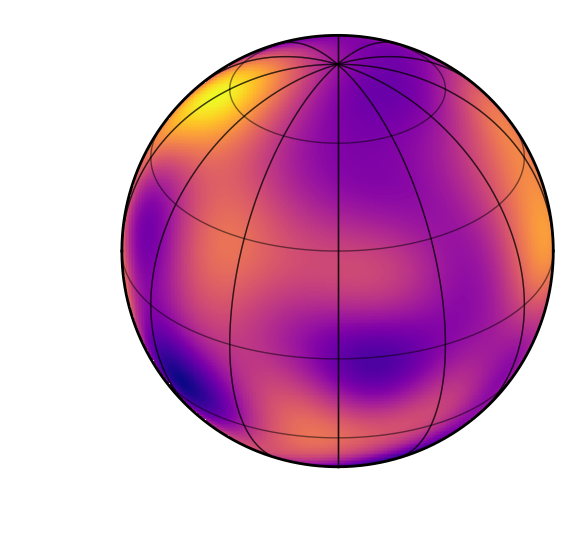

In [5]:
map.show()

Here's a rectangular latitude-longitude view of the map:

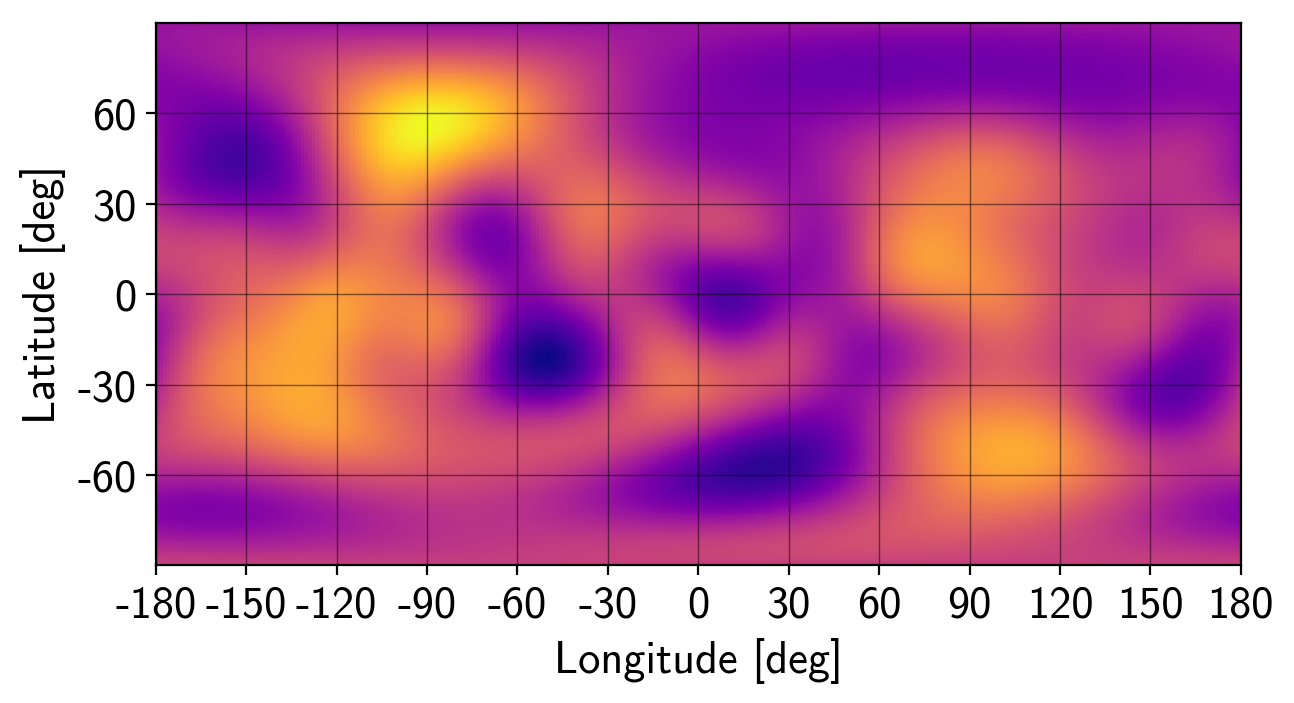

In [6]:
map.show(projection="rect")

And this is the observed light curve over ~3 rotations:

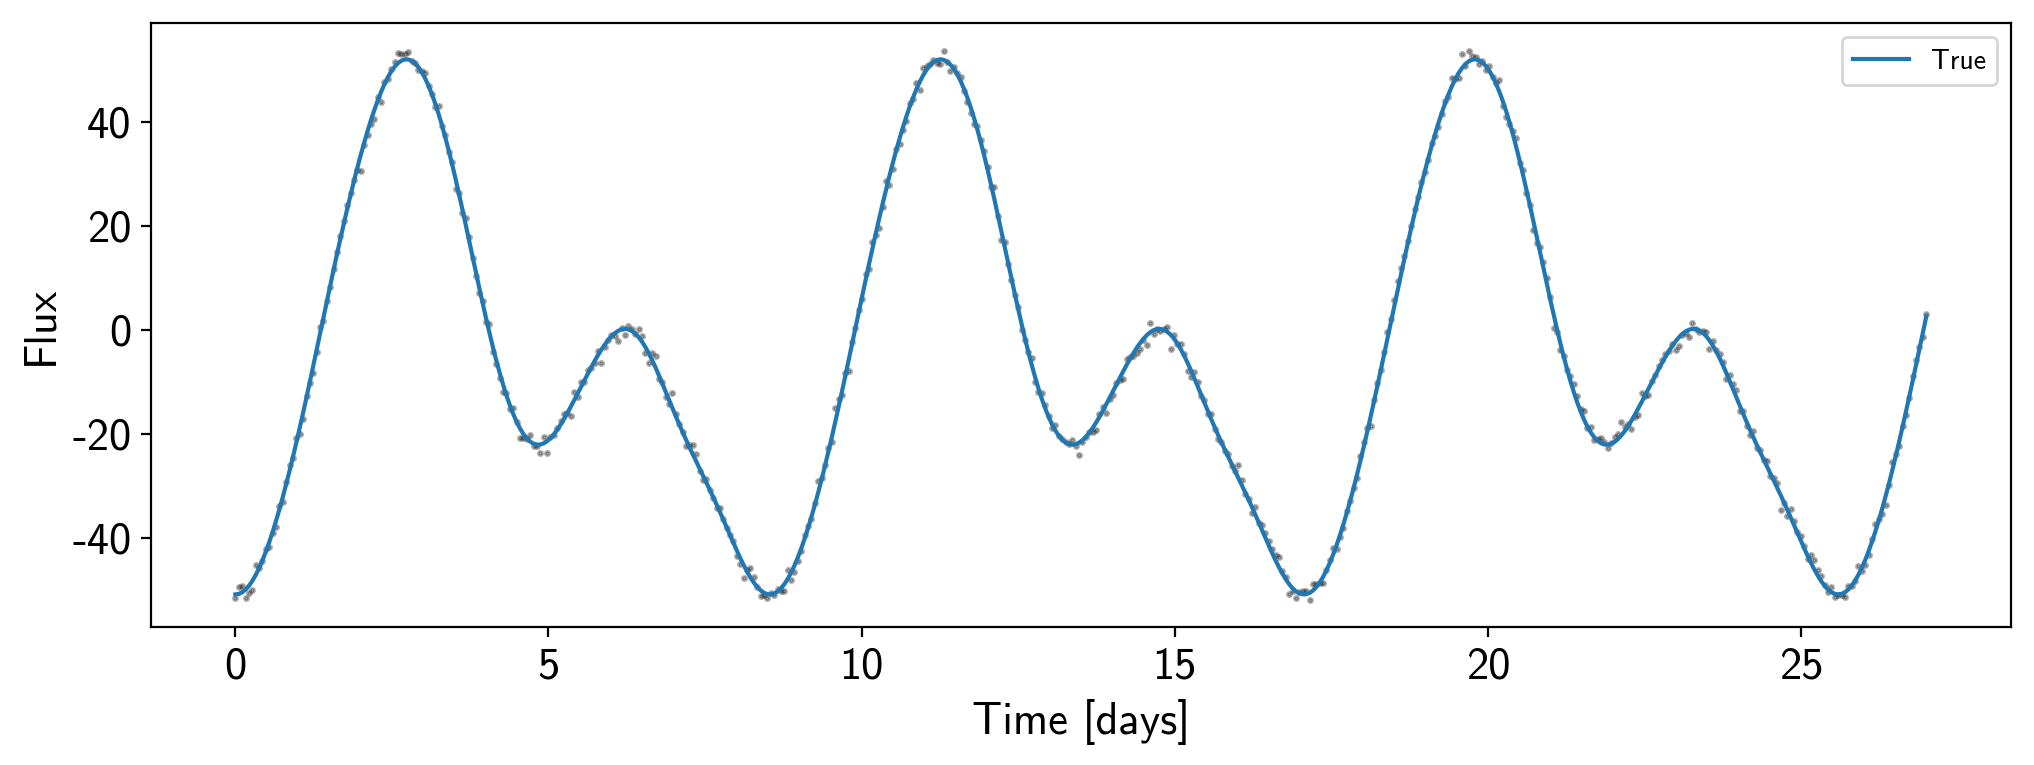

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

## Inference

Define our `PyMC3` model using `starry`. At every step of the chain, we (analytically) solve the least squares problem for the maximum likelihood spherical harmonic coefficients of the map, given the period, inclination, and map power spectrum. The likelihood of the proposal is the likelihood of this best-fit solution plus a correction term that marginalizes over all possible maps.

In [8]:
map = starry.Map(ydeg=truths["ydeg"])
with pm.Model() as model:

    # Priors on the things we're solving for
    period = pm.Uniform("period", 8.4, 8.6)
    inc = pm.Uniform("inc", 50, 90)
     
    # Compute the model using starry
    theta = 360.0 * t / period
    XFull = map.X(theta=theta, inc=inc)
    X0 = XFull[:, 0]
    X = XFull[:, 1:]
    
    # Solve the least squares problem
    XT = X.T / truths["flux_err"] ** 2
    XTX = tt.dot(XT, X)
    LInv = tt.diag(1.0 / truths["power"])
    W = XTX + LInv
    XTf = tt.dot(XT, flux)
    
    # Cholesky decomposition
    cho_W = tt.slinalg.cholesky(W)
    Q = tt.slinalg.solve_lower_triangular(cho_W, XTf)
    y = tt.slinalg.solve_upper_triangular(cho_W.T, Q)
    
    # Get the MAP flux model
    flux_model = tt.dot(X, y)
    
    # L2 penalty on `y`
    pm.Normal("L2", mu=0, sd=np.sqrt(truths["power"]), observed=y)
    
    # Correction for marginal likelihood
    pm.Potential("marginal", -tt.sum(tt.log(tt.diag(cho_W))))
    
    # Track some values for plotting later
    pm.Deterministic("y", y)

    # Save our initial guess
    model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=truths["flux_err"], observed=flux)

/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [9]:
with model:
    map_soln = xo.optimize()

/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr

optimizing logp for variables: ['inc_interval__', 'period_interval__']


ValueError: expected an ndarray
Apply node that caused the error: Elemwise{mul}(<starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.2, TensorConstant{40.0})
Toposort index: 181
Inputs types: [TensorType(float64, scalar), TensorType(float64, scalar)]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [0.07353944596881812, array(40.)]
Inputs type_num: [12, 12]
Outputs clients: [[Elemwise{mul}(Elemwise{mul}.0, sigmoid.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 605, in grad
    grad_dict, wrt, cost_name)
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1371, in _populate_grad_dict
    rval = [access_grad_cache(elem) for elem in wrt]
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1371, in <listcomp>
    rval = [access_grad_cache(elem) for elem in wrt]
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1326, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1021, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1021, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1326, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/anaconda3/lib/python3.7/site-packages/theano/gradient.py", line 1162, in access_term_cache
    new_output_grads)

Debugprint of the apply node: 
Elemwise{mul} [id A] <TensorType(float64, scalar)> ''   
 |<starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.2 [id B] <TensorType(float64, scalar)> ''   
 | |TensorConstant{[]} [id C] <TensorType(float64, vector)>
 | |TensorConstant{[]} [id C] <TensorType(float64, vector)>
 | |Elemwise{add,no_inplace} [id D] <TensorType(float64, scalar)> 'inc'   
 | |TensorConstant{0.0} [id E] <TensorType(float64, scalar)>
 | |Elemwise{mul,no_inplace} [id F] <TensorType(float64, vector)> ''   
 | | |Elemwise{true_div,no_inplace} [id G] <TensorType(float64, vector)> ''   
 | | | |TensorConstant{[   0.    ...        ]} [id H] <TensorType(float64, vector)>
 | | | |InplaceDimShuffle{x} [id I] <TensorType(float64, (True,))> ''   
 | | |   |Elemwise{add,no_inplace} [id J] <TensorType(float64, scalar)> 'period'   
 | | |Reshape{1} [id K] <TensorType(float64, vector)> ''   
 | |   |Elemwise{second,no_inplace} [id L] <TensorType(float64, vector)> ''   
 | |   | |Elemwise{add,no_inplace} [id M] <TensorType(float64, vector)> ''   
 | |   | | |Elemwise{add,no_inplace} [id N] <TensorType(float64, vector)> ''   
 | |   | | | |Elemwise{add,no_inplace} [id O] <TensorType(float64, vector)> ''   
 | |   | | | | |Elemwise{add,no_inplace} [id P] <TensorType(float64, vector)> ''   
 | |   | | | | | |Elemwise{true_div,no_inplace} [id G] <TensorType(float64, vector)> ''   
 | |   | | | | | |TensorConstant{(1,) of 0.0} [id Q] <TensorType(float64, (True,))>
 | |   | | | | |TensorConstant{(1,) of 0.0} [id Q] <TensorType(float64, (True,))>
 | |   | | | |TensorConstant{(1,) of 1.0} [id R] <TensorType(float64, (True,))>
 | |   | | |TensorConstant{(1,) of 0.0} [id Q] <TensorType(float64, (True,))>
 | |   | |TensorConstant{(1,) of 1.0} [id R] <TensorType(float64, (True,))>
 | |   |TensorConstant{(1,) of -1} [id S] <TensorType(int64, (True,))>
 | |Elemwise{mul,no_inplace} [id T] <TensorType(float64, vector)> ''   
 | | |TensorConstant{(1,) of 0.0} [id Q] <TensorType(float64, (True,))>
 | | |Reshape{1} [id K] <TensorType(float64, vector)> ''   
 | |Elemwise{mul,no_inplace} [id T] <TensorType(float64, vector)> ''   
 | |Elemwise{mul,no_inplace} [id U] <TensorType(float64, vector)> ''   
 | | |TensorConstant{(1,) of 1.0} [id R] <TensorType(float64, (True,))>
 | | |Reshape{1} [id K] <TensorType(float64, vector)> ''   
 | |Elemwise{mul,no_inplace} [id T] <TensorType(float64, vector)> ''   
 | |IncSubtensor{Inc;::, int64::} [id V] <TensorType(float64, matrix)> ''   
 |   |Elemwise{second,no_inplace} [id W] <TensorType(float64, matrix)> ''   
 |   | |<starry.Map.ops.ylm.YlmXOp object at 0x1c26d40c18> [id X] <TensorType(float64, matrix)> ''   
 |   | | |TensorConstant{[]} [id C] <TensorType(float64, vector)>
 |   | | |TensorConstant{[]} [id C] <TensorType(float64, vector)>
 |   | | |Elemwise{add,no_inplace} [id D] <TensorType(float64, scalar)> 'inc'   
 |   | | |TensorConstant{0.0} [id E] <TensorType(float64, scalar)>
 |   | | |Elemwise{mul,no_inplace} [id F] <TensorType(float64, vector)> ''   
 |   | | |Elemwise{mul,no_inplace} [id T] <TensorType(float64, vector)> ''   
 |   | | |Elemwise{mul,no_inplace} [id T] <TensorType(float64, vector)> ''   
 |   | | |Elemwise{mul,no_inplace} [id U] <TensorType(float64, vector)> ''   
 |   | | |Elemwise{mul,no_inplace} [id T] <TensorType(float64, vector)> ''   
 |   | |TensorConstant{(1, 1) of 0.0} [id Y] <TensorType(float64, (True, True))>
 |   |Elemwise{add,no_inplace} [id Z] <TensorType(float64, matrix)> ''   
 |   | |Elemwise{add,no_inplace} [id BA] <TensorType(float64, matrix)> ''   
 |   | | |InplaceDimShuffle{1,0} [id BB] <TensorType(float64, matrix)> ''   
 |   | | | |Elemwise{true_div} [id BC] <TensorType(float64, matrix)> ''   
 |   | | |   |Elemwise{add,no_inplace} [id BD] <TensorType(float64, matrix)> ''   
 |   | | |   | |Dot22 [id BE] <TensorType(float64, matrix)> ''   
 |   | | |   | | |Elemwise{sub,no_inplace} [id BF] <TensorType(float64, matrix)> ''   
 |   | | |   | | | |Elemwise{mul,no_inplace} [id BG] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | |Elemwise{add,no_inplace} [id BH] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id BI] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |InplaceDimShuffle{1,0} [id BJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | | |Cholesky{lower=True, destructive=False, on_error='raise'} [id BK] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |   |Elemwise{add,no_inplace} [id BL] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     |Dot22 [id BM] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     | |Elemwise{true_div,no_inplace} [id BN] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     | | |InplaceDimShuffle{1,0} [id BO] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     | | | |Subtensor{::, int64::} [id BP] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     | | |   |<starry.Map.ops.ylm.YlmXOp object at 0x1c26d40c18> [id X] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     | | |   |Constant{1} [id BQ] <int64>
 |   | | |   | | | | | | |     | | |TensorConstant{(1, 1) of 1.0} [id BR] <TensorType(float32, (True, True))>
 |   | | |   | | | | | | |     | |Subtensor{::, int64::} [id BP] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | | |     |TensorConstant{[[0.000528..12933532]]} [id BS] <TensorType(float64, matrix)>
 |   | | |   | | | | | | |InplaceDimShuffle{1,0} [id BT] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |   |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id BU] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |     |InplaceDimShuffle{1,0} [id BJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |     |InplaceDimShuffle{1,0} [id BV] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |       |Elemwise{sub,no_inplace} [id BW] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         |Elemwise{mul,no_inplace} [id BX] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |Dot22 [id BY] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | | |InplaceDimShuffle{1,0} [id BJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | | |Elemwise{add,no_inplace} [id BZ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |Elemwise{add,no_inplace} [id CA] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |InplaceDimShuffle{1,0} [id CB] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | | |Elemwise{mul,no_inplace} [id CC] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |Elemwise{neg,no_inplace} [id CD] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   | |Dot22 [id CE] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |InplaceDimShuffle{0,x} [id CF] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   | |   |   | |Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False} [id CG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |   |InplaceDimShuffle{1,0} [id CH] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |   | |InplaceDimShuffle{1,0} [id BJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |   |Elemwise{add,no_inplace} [id CI] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     |Elemwise{mul} [id CJ] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | |Elemwise{mul} [id CK] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | |Elemwise{mul} [id CL] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | |Elemwise{true_div} [id CM] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |Elemwise{second} [id CN] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | |Elemwise{true_div,no_inplace} [id CO] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | |Elemwise{add,no_inplace} [id CP] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |Elemwise{mul,no_inplace} [id CQ] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | | |TensorConstant{[-0.000528...12933532]} [id CR] <TensorType(float64, vector)>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | | |Elemwise{pow,no_inplace} [id CS] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   |Elemwise{sub,no_inplace} [id CT] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id CU] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | | |InplaceDimShuffle{1,0} [id BJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | | |Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False} [id CV] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |   |Cholesky{lower=True, destructive=False, on_error='raise'} [id BK] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |   |InplaceDimShuffle{0} [id CW] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |     |Dot22 [id CX] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |       |Elemwise{true_div,no_inplace} [id BN] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |       |TensorConstant{[[-5.16063..1955e+00]]} [id CY] <TensorType(float64, col)>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   | |TensorConstant{(1,) of 0} [id CZ] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |   |TensorConstant{(1,) of 2} [id DA] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | | |TensorConstant{[-9.383223...88322397]} [id DB] <TensorType(float64, vector)>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | | |TensorConstant{(1,) of 2.0} [id DC] <TensorType(float32, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | | |InplaceDimShuffle{x} [id DD] <TensorType(float64, (True,))> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |   |InplaceDimShuffle{} [id DE] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |     |Subtensor{int64} [id DF] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       |Elemwise{second} [id DG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | |MakeVector{dtype='float64'} [id DH] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | | |Elemwise{add,no_inplace} [id DI] <TensorType(float64, scalar)> '__logp_period_interval__'   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | | |Elemwise{add,no_inplace} [id DJ] <TensorType(float64, scalar)> '__logp_inc_interval__'   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | | |Sum{acc_dtype=float64} [id DK] <TensorType(float64, scalar)> '__logp_L2'   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | | |Sum{acc_dtype=float64} [id DL] <TensorType(float64, scalar)> '__logp_obs'   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | | |Elemwise{neg,no_inplace} [id DM] <TensorType(float64, scalar)> 'marginal'   
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       | |TensorConstant{(1,) of -1.0} [id DN] <TensorType(float64, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |       |Constant{2} [id DO] <int64>
 |   | | |   | | | | | |         | |   | |   |   |     | | | | |TensorConstant{(1,) of 2.0} [id DC] <TensorType(float32, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     | | | |TensorConstant{[-0.000528...12933532]} [id CR] <TensorType(float64, vector)>
 |   | | |   | | | | | |         | |   | |   |   |     | | |TensorConstant{(1,) of 2} [id DA] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     | |Elemwise{pow} [id DP] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     |   |Elemwise{sub,no_inplace} [id CT] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |     |   |TensorConstant{(1,) of 1} [id DQ] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |     |InplaceDimShuffle{0} [id DR] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |       |Dot22 [id DS] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   | |   |   |         |InplaceDimShuffle{1,0} [id BO] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |         |InplaceDimShuffle{0,x} [id DT] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   | |   |   |           |Elemwise{neg} [id DU] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |             |Elemwise{mul} [id DV] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               |Elemwise{mul} [id DW] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | |Elemwise{mul} [id DX] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | |Elemwise{true_div} [id DY] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | |Elemwise{second} [id DZ] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | |Elemwise{true_div,no_inplace} [id EA] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | |Elemwise{add,no_inplace} [id EB] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |Elemwise{mul,no_inplace} [id EC] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | | |TensorConstant{(1,) of -1.0} [id DN] <TensorType(float64, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | | |Elemwise{pow,no_inplace} [id ED] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   |Elemwise{sub,no_inplace} [id EE] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   | |TensorConstant{[-5.160631..51955e+00]} [id EF] <TensorType(float64, vector)>
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   | |InplaceDimShuffle{0} [id EG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   |   |Dot22 [id EH] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   |     |Subtensor{::, int64::} [id BP] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   |     |InplaceDimShuffle{0,x} [id EI] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   |       |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id CU] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |   |TensorConstant{(1,) of 2} [id DA] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | | |TensorConstant{(1,) of -1..0664093453} [id EJ] <TensorType(float64, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               | | | | | |TensorConstant{(1,) of 2.0} [id DC] <TensorType(float32, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               | | | | |InplaceDimShuffle{x} [id EK] <TensorType(float64, (True,))> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | |   |InplaceDimShuffle{} [id EL] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | |     |Subtensor{int64} [id EM] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | |       |Elemwise{second} [id DG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |               | | | |       |Constant{3} [id EN] <int64>
 |   | | |   | | | | | |         | |   | |   |   |               | | | |TensorConstant{(1,) of 2.0} [id DC] <TensorType(float32, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               | | |TensorConstant{(1,) of -1.0} [id DN] <TensorType(float64, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               | |TensorConstant{(1,) of 2} [id DA] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |               |Elemwise{pow} [id EO] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |                 |Elemwise{sub,no_inplace} [id EE] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |   |                 |TensorConstant{(1,) of 1} [id DQ] <TensorType(int8, (True,))>
 |   | | |   | | | | | |         | |   | |   |   |InplaceDimShuffle{x,0} [id EP] <TensorType(float64, row)> ''   
 |   | | |   | | | | | |         | |   | |   |     |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id CU] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   | |   |Elemwise{sub,no_inplace} [id EQ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |     |TensorConstant{(1, 1) of 1} [id ER] <TensorType(int8, (True, True))>
 |   | | |   | | | | | |         | |   | |     |Tri{dtype='float64'} [id ES] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |       |Subtensor{int64} [id ET] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         | |   | |       | |Shape [id EU] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         | |   | |       | | |Elemwise{neg,no_inplace} [id CD] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   | |       | |Constant{0} [id EV] <int64>
 |   | | |   | | | | | |         | |   | |       |Subtensor{int64} [id EW] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         | |   | |       | |Shape [id EU] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         | |   | |       | |Constant{1} [id BQ] <int64>
 |   | | |   | | | | | |         | |   | |       |TensorConstant{-1} [id EX] <TensorType(int8, scalar)>
 |   | | |   | | | | | |         | |   | |Elemwise{mul,no_inplace} [id EY] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |   |Elemwise{neg,no_inplace} [id EZ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |   | |Dot22 [id FA] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |   |   |InplaceDimShuffle{0,x} [id FB] <TensorType(float64, col)> ''   
 |   | | |   | | | | | |         | |   |   |   | |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id FC] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   |   |   |   |InplaceDimShuffle{1,0} [id BJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |   |   |   |Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False} [id CG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   |   |   |InplaceDimShuffle{x,0} [id FD] <TensorType(float64, row)> ''   
 |   | | |   | | | | | |         | |   |   |     |Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False} [id CV] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |   |   |Tri{dtype='float64'} [id FE] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |     |Subtensor{int64} [id FF] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         | |   |     | |Shape [id FG] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         | |   |     | | |Elemwise{neg,no_inplace} [id EZ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |   |     | |Constant{0} [id EV] <int64>
 |   | | |   | | | | | |         | |   |     |Subtensor{int64} [id FH] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         | |   |     | |Shape [id FG] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         | |   |     | |Constant{1} [id BQ] <int64>
 |   | | |   | | | | | |         | |   |     |TensorConstant{0} [id FI] <TensorType(int8, scalar)>
 |   | | |   | | | | | |         | |   |IncSubtensor{Set;:int64:, :int64:} [id FJ] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |     |Elemwise{second,no_inplace} [id FK] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |     | |Cholesky{lower=True, destructive=False, on_error='raise'} [id BK] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |     | |TensorConstant{(1, 1) of 0.0} [id Y] <TensorType(float64, (True, True))>
 |   | | |   | | | | | |         | |     |AllocDiag{offset=0, axis1=0, axis2=1} [id FL] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |     | |Elemwise{true_div} [id FM] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |     |   |Elemwise{second} [id FN] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |     |   | |Elemwise{log,no_inplace} [id FO] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |     |   | | |ExtractDiag{offset=0, axis1=0, axis2=1, view=False} [id FP] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |     |   | |   |Cholesky{lower=True, destructive=False, on_error='raise'} [id BK] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |     |   | |InplaceDimShuffle{x} [id FQ] <TensorType(float64, (True,))> ''   
 |   | | |   | | | | | |         | |     |   |   |Elemwise{neg} [id FR] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |     |   |     |InplaceDimShuffle{} [id FS] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |     |   |       |Subtensor{int64} [id FT] <TensorType(float64, scalar)> ''   
 |   | | |   | | | | | |         | |     |   |         |Elemwise{second} [id DG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |     |   |         |Constant{4} [id FU] <int64>
 |   | | |   | | | | | |         | |     |   |ExtractDiag{offset=0, axis1=0, axis2=1, view=False} [id FP] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |         | |     |ScalarFromTensor [id FV] <int64> ''   
 |   | | |   | | | | | |         | |     | |Subtensor{int64} [id FW] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         | |     |   |Shape [id FX] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         | |     |   | |AllocDiag{offset=0, axis1=0, axis2=1} [id FL] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         | |     |   |Constant{0} [id EV] <int64>
 |   | | |   | | | | | |         | |     |ScalarFromTensor [id FY] <int64> ''   
 |   | | |   | | | | | |         | |       |Subtensor{int64} [id FZ] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         | |         |Shape [id FX] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         | |         |Constant{1} [id BQ] <int64>
 |   | | |   | | | | | |         | |Tri{dtype='float64'} [id GA] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         |   |Subtensor{int64} [id GB] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         |   | |Shape [id GC] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         |   | | |Dot22 [id BY] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |         |   | |Constant{0} [id EV] <int64>
 |   | | |   | | | | | |         |   |Subtensor{int64} [id GD] <TensorType(int64, scalar)> ''   
 |   | | |   | | | | | |         |   | |Shape [id GC] <TensorType(int64, vector)> ''   
 |   | | |   | | | | | |         |   | |Constant{1} [id BQ] <int64>
 |   | | |   | | | | | |         |   |TensorConstant{0} [id FI] <TensorType(int8, scalar)>
 |   | | |   | | | | | |         |AllocDiag{offset=0, axis1=0, axis2=1} [id GE] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |           |Elemwise{true_div,no_inplace} [id GF] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |             |ExtractDiag{offset=0, axis1=0, axis2=1, view=False} [id GG] <TensorType(float64, vector)> ''   
 |   | | |   | | | | | |             | |Dot22 [id BY] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | | |             |TensorConstant{(1,) of 2.0} [id DC] <TensorType(float32, (True,))>
 |   | | |   | | | | | |InplaceDimShuffle{1,0} [id GH] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | |   |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id BI] <TensorType(float64, matrix)> ''   
 |   | | |   | | | | |Tri{dtype='float64'} [id GI] <TensorType(float64, matrix)> ''   
 |   | | |   | | | |   |Subtensor{int64} [id GJ] <TensorType(int64, scalar)> ''   
 |   | | |   | | | |   | |Shape [id GK] <TensorType(int64, vector)> ''   
 |   | | |   | | | |   | | |Elemwise{add,no_inplace} [id BH] <TensorType(float64, matrix)> ''   
 |   | | |   | | | |   | |Constant{0} [id EV] <int64>
 |   | | |   | | | |   |Subtensor{int64} [id GL] <TensorType(int64, scalar)> ''   
 |   | | |   | | | |   | |Shape [id GK] <TensorType(int64, vector)> ''   
 |   | | |   | | | |   | |Constant{1} [id BQ] <int64>
 |   | | |   | | | |   |TensorConstant{0} [id FI] <TensorType(int8, scalar)>
 |   | | |   | | | |AllocDiag{offset=0, axis1=0, axis2=1} [id GM] <TensorType(float64, matrix)> ''   
 |   | | |   | | |   |ExtractDiag{offset=0, axis1=0, axis2=1, view=False} [id GN] <TensorType(float64, vector)> ''   
 |   | | |   | | |     |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id BI] <TensorType(float64, matrix)> ''   
 |   | | |   | | |InplaceDimShuffle{1,0} [id BO] <TensorType(float64, matrix)> ''   
 |   | | |   | |Dot22 [id GO] <TensorType(float64, matrix)> ''   
 |   | | |   |   |InplaceDimShuffle{0,x} [id FB] <TensorType(float64, col)> ''   
 |   | | |   |   |TensorConstant{[[-5.16063..1955e+00]]} [id GP] <TensorType(float64, row)>
 |   | | |   |TensorConstant{(1, 1) of 1.0} [id BR] <TensorType(float32, (True, True))>
 |   | | |Dot22 [id GQ] <TensorType(float64, matrix)> ''   
 |   | |   |InplaceDimShuffle{1,0} [id GR] <TensorType(float64, matrix)> ''   
 |   | |   | |Elemwise{true_div,no_inplace} [id BN] <TensorType(float64, matrix)> ''   
 |   | |   |Elemwise{sub,no_inplace} [id BF] <TensorType(float64, matrix)> ''   
 |   | |Dot22 [id GS] <TensorType(float64, matrix)> ''   
 |   |   |InplaceDimShuffle{0,x} [id GT] <TensorType(float64, col)> ''   
 |   |   | |Elemwise{neg} [id DU] <TensorType(float64, vector)> ''   
 |   |   |InplaceDimShuffle{x,0} [id GU] <TensorType(float64, row)> ''   
 |   |     |InplaceDimShuffle{0} [id GV] <TensorType(float64, vector)> ''   
 |   |       |Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False} [id CU] <TensorType(float64, vector)> ''   
 |   |Constant{1} [id BQ] <int64>
 |TensorConstant{40.0} [id GW] <TensorType(float64, scalar)>

Storage map footprint:
 - TensorConstant{[[0.000528..12933532]]}, Shape: (120, 120), ElemSize: 8 Byte(s), TotalSize: 115200 Byte(s)
 - TensorConstant{[   0.    ...        ]}, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - Reshape{1}.0, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - TensorConstant{[[-5.16063..1955e+00]]}, Shape: (500, 1), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - TensorConstant{[-5.160631..51955e+00]}, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - TensorConstant{[[-5.16063..1955e+00]]}, Shape: (1, 500), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.4, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.5, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.6, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.7, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.8, Shape: (500,), ElemSize: 8 Byte(s), TotalSize: 4000 Byte(s)
 - TensorConstant{[-0.000528...12933532]}, Shape: (120,), ElemSize: 8 Byte(s), TotalSize: 960 Byte(s)
 - TensorConstant{[-9.383223...88322397]}, Shape: (120,), ElemSize: 8 Byte(s), TotalSize: 960 Byte(s)
 - Elemwise{second}.0, Shape: (5,), ElemSize: 8 Byte(s), TotalSize: 40 Byte(s)
 - period_interval__, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - inc_interval__, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - sigmoid.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.1999999999999993}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{8.4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - InplaceDimShuffle{x}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 0.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 1.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - sigmoid.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{40.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{50.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of -1.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1..0664093453}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{3.6888794541139363}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{90.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-3.6888794541139363}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{neg,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-1.6094379124341038}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{8.6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1.6094379124341038}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{neg,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.0}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 1.0}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1,) of 2.0}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{-inf}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{(1,) of 2}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{(1,) of 0}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1, 1) of 1}, Shape: (1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{[]}, Shape: (0,), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.0, Shape: (0,), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 - <starry.Map.ops.ylm.YlmXGradientOp object at 0x1c26d40ba8>.1, Shape: (0,), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 157464.0 Byte(s) 0.000 GB
 TotalSize inputs: 133352.0 Byte(s) 0.000 GB



In [ ]:
# Timing test
with model:
    func = xo.get_theano_function_for_var(model.logpt)
    grad = xo.get_theano_function_for_var(theano.grad(model.logpt, model.vars))
    vars = xo.get_args_for_theano_function()
    func(*vars)
    grad(*vars)
    %timeit func(*vars)
    %timeit grad(*vars)
    pfunc = xo.get_theano_function_for_var(model.logpt, profile=True)
    pfunc(*vars)
    pgrad = xo.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    pgrad(*vars)
    pfunc.profile.summary()
    pgrad.profile.summary()

map_soln

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.plot(t, model_guess, label="Initial")
ax.plot(t, xo.eval_in_model(flux_model, map_soln, model=model), label="MAP")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

Now we sample the posterior. (Check out [this issue](https://github.com/Theano/Theano/issues/6667) for details on the warning we're getting.)

In [ ]:
sampler = xo.PyMC3Sampler(window=100, finish=200, cores=1)
with model:
    burnin = sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Visualize the results:

In [ ]:
varnames = ["period", "inc"]
pm.summary(trace, varnames=varnames)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples, truths=[truths["period"], truths["inc"]]);

In [ ]:
for i in range(3):
    j = np.random.randint(len(trace["y"]))
    map[1:, :] = trace["y"][j]
    map.show(projection="rect")